# Imports

In [1]:
import sys, os

sys.path.append(os.path.join("..", "src"))

from sindy_core import SINDyModel, SINDyConfig
from derivatives import (  # 👈 new
    finite_difference_derivative,
    sgolay_derivative,
    tv_derivative,
)
from systems import LorenzDefinition
from plotting import (
    plot_time_series,
    plot_phase,
    plot_3d,
    plot_time_series_comparison,
    plot_3d_comparison,
    plot_error_time_series,
)
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

# Synthetic data verification

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Duffing oscillator: phase portrait (x vs v)'}, xlabel='x0', ylabel='x1'>)

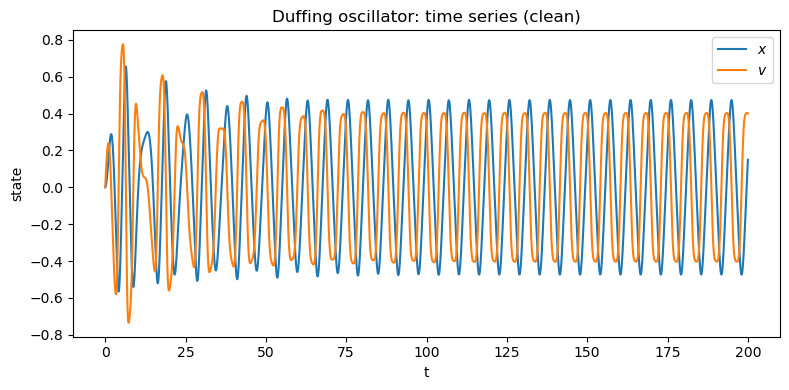

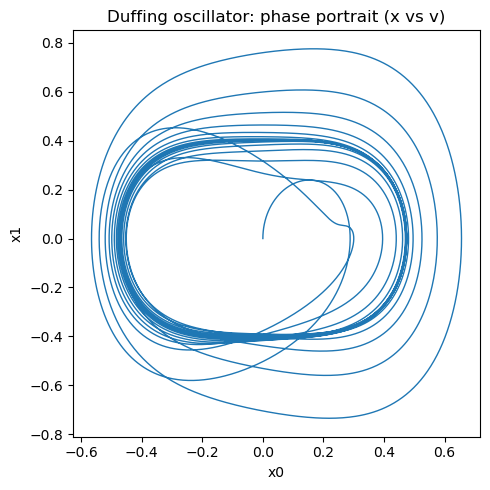

In [2]:
# 03_duffing.ipynb — setup block


import jax.numpy as jnp
import jax.random as jr
import numpy as np

from systems import ProblemDefinition
from plotting import (
    plot_time_series,
    plot_phase,
    plot_error_time_series,
)

# you'll also import SINDyConfig, SINDyModel, PolynomialLibrary, FourierLibrary later


class DuffingDefinition(ProblemDefinition):
    """
    Forced Duffing oscillator in first-order form:

        ẋ = v
        v̇ = γ cos(ω t) − δ v − α x − β x^3

    parameters dict should contain:
        "alpha", "beta", "gamma", "delta", "omega"
    """

    def __init__(
        self,
        parameters: dict,
        x0_vector: jnp.ndarray,
        t0: float,
        tf: float,
        dt: float,
    ):
        super().__init__(
            name="Duffing",
            state_dim=2,
            parameters=parameters,
            x0_vector=x0_vector,
            t0=t0,
            tf=tf,
            dt=dt,
        )

    def rhs(self, t, x):
        alpha = self.parameters["alpha"]
        beta = self.parameters["beta"]
        gamma = self.parameters["gamma"]
        delta = self.parameters["delta"]
        omega = self.parameters["omega"]

        pos = x[0]
        vel = x[1]

        dxdt = vel
        dvdt = (
            gamma * jnp.cos(omega * t)
            - delta * vel
            - alpha * pos
            - beta * pos**3
        )
        return jnp.array([dxdt, dvdt])


# ---------- clean Duffing sim + quick plots ----------

duffing_params = {
    "alpha": 1.0,
    "beta": 5.0,
    "gamma": 0.37,
    "delta": 0.1,
    "omega": 1.0,
}
x0_duffing = jnp.array([0.0, 0.0])

duffing = DuffingDefinition(
    parameters=duffing_params,
    x0_vector=x0_duffing,
    t0=0.0,
    tf=200.0,
    dt=0.01,
)

ts, xs = duffing.simulate()  # xs: (N, 2), columns [x, v]

plot_time_series(
    ts,
    xs,
    labels=[r"$x$", r"$v$"],
    title="Duffing oscillator: time series (clean)",
)

plot_phase(xs, i=0, j=1, title="Duffing oscillator: phase portrait (x vs v)")

# Full duffing SINDy implementation

In [4]:
from systems import DuffingDefinition

duff_params = {
    "alpha": 1.0,
    "beta": 5.0,
    "gamma": 0.37,
    "delta": 0.1,
    "omega": 1.0,
}
x0_duff = jnp.array([0.0, 0.0])  # [x, v]

duffing = DuffingDefinition(
    parameters=duff_params,
    x0_vector=x0_duff,
    t0=0.0,
    tf=200.0,
    dt=0.01,
)

In [5]:
# === Duffing: full run using STLSQ from sindy_core (FD + poly+Fourier) ===
from sindy_core import SINDyConfig, SINDyModel
from derivatives import finite_difference_derivative

# simulate + subsample
ts, xs = duffing.simulate()
k_sub = 10
ts = ts[::k_sub]
xs = xs[::k_sub, :]

Xdot_fd = finite_difference_derivative(ts, xs)

crop = slice(1, -1)
ts_c = ts[crop]
X = xs[crop, :]
Xdot = Xdot_fd[crop, :]

cfg_duff = SINDyConfig(
    poly_degree=3,
    include_bias=True,
    threshold=0.1,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "v"),
    mode="polynomial_and_fourier",
    k_max=5,
    include_sin=True,
    include_cos=True,
    fourier_prefix="t",
)

model_duff = SINDyModel(cfg_duff).fit(X, Xdot, ts=ts_c)

print("=== Duffing SINDy model (polynomial_and_fourier, FD, clean) ===")
model_duff.print()

=== Duffing SINDy model (polynomial_and_fourier, FD, clean) ===
dx/dt = 0.997932*v
dv/dt = -1.01017*x - 0.0996468*v - 4.91141*x^3 + 0.368736*cos(1t)


Trajectory RMSE (Duffing, SINDy vs true): 0.008


(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Duffing SINDy: x vs v'}, xlabel='x0', ylabel='x1'>)

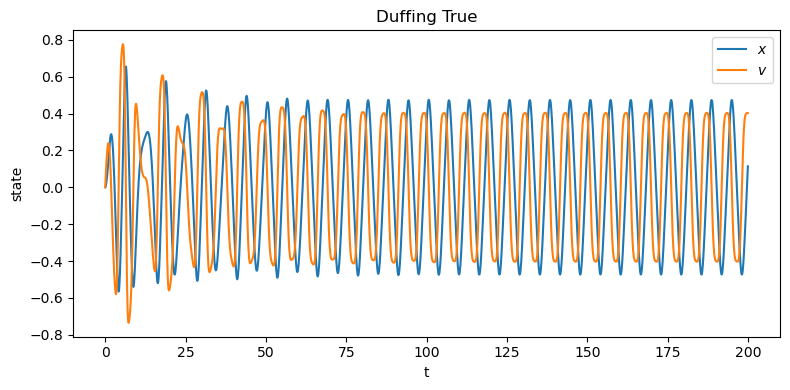

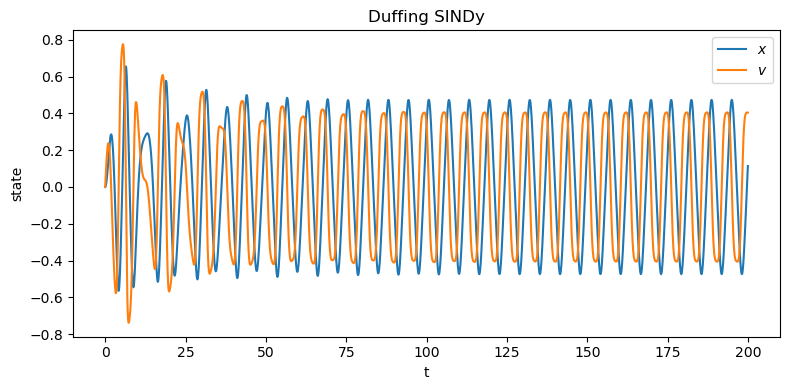

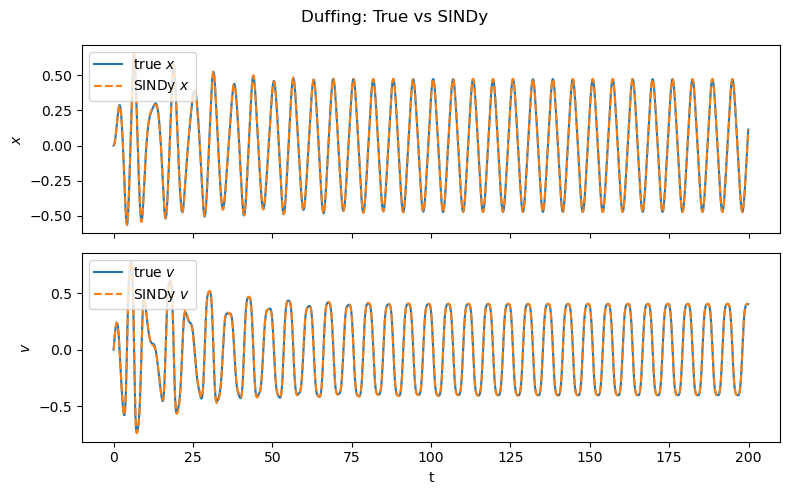

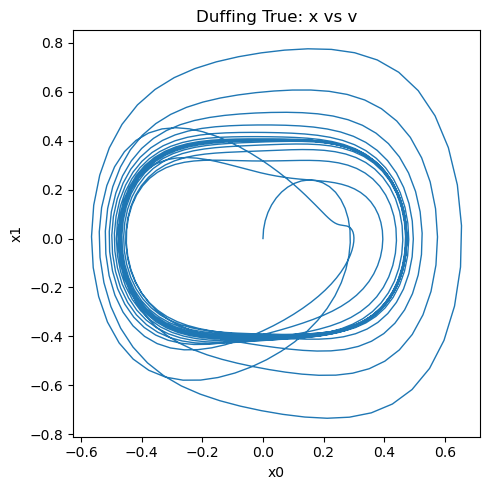

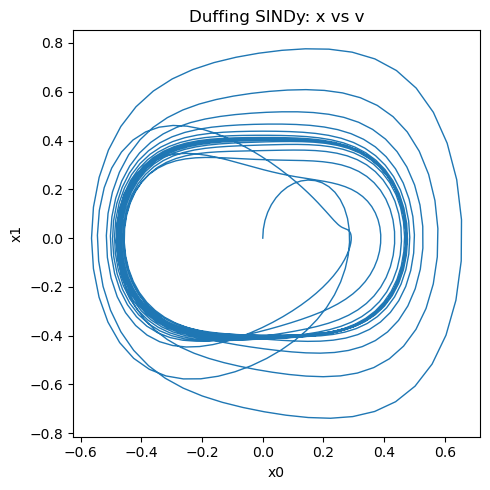

In [6]:
import numpy as np
from sindy_core import (
    build_polynomial_block,
    build_fourier_block,
    combine_libraries,
)

# ---------- 1. SINDy RHS for Duffing (time-dependent) ----------


def duffing_sindy_rhs(t, x, model, cfg):
    """
    Evaluate learned SINDy Duffing model at (t, x).
    Uses polynomial_and_fourier library, same as during fitting.
    """
    x = np.asarray(x, dtype=float)[None, :]  # shape (1, 2)

    # polynomial part in [x, v]
    Theta_poly, _, _ = build_polynomial_block(
        x,
        degree=cfg.poly_degree,
        include_bias=cfg.include_bias,
        var_names=list(cfg.var_names),
    )

    # fourier part in time t
    Theta_four, _, _ = build_fourier_block(
        np.array([t], dtype=float),
        k_max=cfg.k_max,
        include_sin=cfg.include_sin,
        include_cos=cfg.include_cos,
        prefix=cfg.fourier_prefix,
    )

    Theta, _ = combine_libraries(
        [
            (Theta_poly, []),
            (Theta_four, []),
        ]
    )  # shape (1, p)

    dxdt = np.asarray(Theta @ np.asarray(model.Xi))[0]  # shape (2,)
    return dxdt


# ---------- 2. RK4 simulation of learned SINDy Duffing ----------

t = np.asarray(ts, dtype=float)  # true time grid from duffing.simulate()
xs_true = np.asarray(xs, dtype=float)  # true Duffing trajectory (N, 2)

N = t.size
dts = np.diff(t)

xs_sindy = np.zeros_like(xs_true)
xs_sindy[0] = xs_true[0]  # same IC as true system

for k in range(N - 1):
    h = dts[k]
    tk = t[k]
    xk = xs_sindy[k]

    k1 = duffing_sindy_rhs(tk, xk, model_duff, cfg_duff)
    k2 = duffing_sindy_rhs(
        tk + 0.5 * h, xk + 0.5 * h * k1, model_duff, cfg_duff
    )
    k3 = duffing_sindy_rhs(
        tk + 0.5 * h, xk + 0.5 * h * k2, model_duff, cfg_duff
    )
    k4 = duffing_sindy_rhs(tk + h, xk + h * k3, model_duff, cfg_duff)

    xs_sindy[k + 1] = xk + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# ---------- 3. Trajectory RMSE vs true Duffing ----------

err = np.linalg.norm(xs_true - xs_sindy, axis=1)
rmse_traj = np.sqrt(np.mean(err**2))
print(f"Trajectory RMSE (Duffing, SINDy vs true): {rmse_traj:.3f}")

plot_time_series(t, xs_true, labels=[r"$x$", r"$v$"], title="Duffing True")
plot_time_series(t, xs_sindy, labels=[r"$x$", r"$v$"], title="Duffing SINDy")
plot_time_series_comparison(
    t,
    xs_true,
    xs_sindy,
    labels=[r"$x$", r"$v$"],
    title="Duffing: True vs SINDy",
)
plot_phase(xs_true, i=0, j=1, title="Duffing True: x vs v")
plot_phase(xs_sindy, i=0, j=1, title="Duffing SINDy: x vs v")